![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png)

<h2> Training, Validation and Testing </h2>
We've seen the basics of creating a Pytorch Model and how we can train it to optimise some objective. We'll now see how we can make our training code cleaner and introduce the concept of training/validation/testing data splits!

In [1]:
import torch
import torchvision
import torch.nn as nn

import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create some data similar to the intro notebook
num_training_data = 1000
num_validation_data = 500
num_test_data = 200

# Define the mean and covariance for two random data distributions 
class_1_cov = torch.FloatTensor([[1.0, 0.25], [0.25, 1.4]])
class_1_mu = torch.FloatTensor([[1, -1.5]])

class_2_cov = torch.FloatTensor([[2, -0.5], [-0.5, 1]])
class_2_mu = torch.FloatTensor([[-2, -3]])

In [3]:
# Create Training Data
class_1_train_data = torch.randn(num_training_data, 2)
class_1_train_data = torch.mm(class_1_train_data, class_1_cov) + class_1_mu

class_2_train_data = torch.randn(num_training_data, 2)
class_2_train_data = torch.mm(class_2_train_data, class_2_cov) + class_2_mu

class_1_train_labels = torch.zeros(num_training_data, 1)
class_2_train_labels = torch.ones(num_training_data, 1)

train_data = torch.cat((class_1_train_data, class_2_train_data), 0)
train_labels = torch.cat((class_1_train_labels, class_2_train_labels), 0)

Text(0.5, 1.0, 'Training Data')

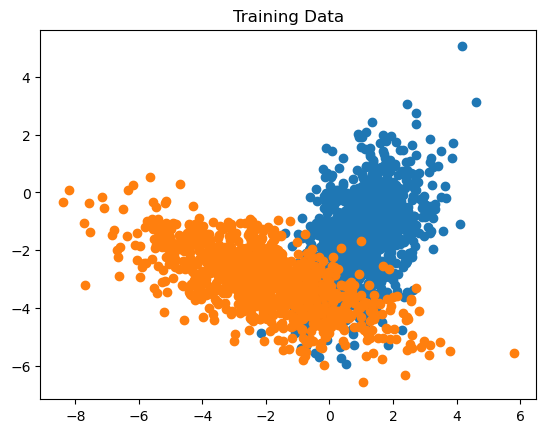

In [4]:
# Lets have a look at the two data distributions, are they going to be linearly separable?
plt.scatter(class_1_train_data[:, 0], class_1_train_data[:, 1])
plt.scatter(class_2_train_data[:, 0], class_2_train_data[:, 1])
plt.title("Training Data")

In [5]:
# Create Validation Data
class_1_val_data = torch.randn(num_validation_data, 2)
class_1_val_data = torch.mm(class_1_val_data, class_1_cov) + class_1_mu

class_2_val_data = torch.randn(num_validation_data, 2)
class_2_val_data = torch.mm(class_2_val_data, class_2_cov) + class_2_mu

class_1_val_labels = torch.zeros(num_validation_data, 1)
class_2_val_labels = torch.ones(num_validation_data, 1)

val_data = torch.cat((class_1_val_data, class_2_val_data), 0)
val_labels = torch.cat((class_1_val_labels, class_2_val_labels), 0)

Text(0.5, 1.0, 'Validation Data')

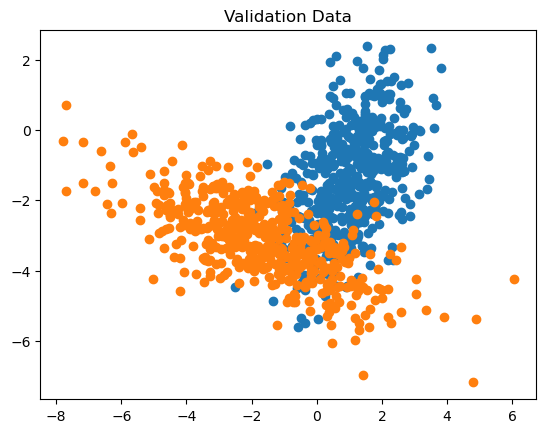

In [6]:
# Lets have a look at the two data distributions, are they going to be linearly separable?
plt.scatter(class_1_val_data[:, 0], class_1_val_data[:, 1])
plt.scatter(class_2_val_data[:, 0], class_2_val_data[:, 1])
plt.title("Validation Data")

In [7]:
# Create Test Data
class_1_test_data = torch.randn(num_test_data, 2)
class_1_test_data = torch.mm(class_1_test_data, class_1_cov) + class_1_mu

class_2_test_data = torch.randn(num_test_data, 2)
class_2_test_data = torch.mm(class_2_test_data, class_2_cov) + class_2_mu

class_1_test_labels = torch.zeros(num_test_data, 1)
class_2_test_labels = torch.ones(num_test_data, 1)

test_data = torch.cat((class_1_test_data, class_2_test_data), 0)
test_labels = torch.cat((class_1_test_labels, class_2_test_labels), 0)

Text(0.5, 1.0, 'Test Data')

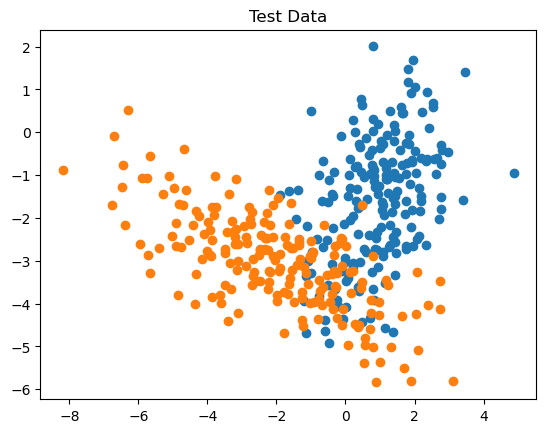

In [8]:
# Lets have a look at the two data distributions, are they going to be linearly separable?
plt.scatter(class_1_test_data[:, 0], class_1_test_data[:, 1])
plt.scatter(class_2_test_data[:, 0], class_2_test_data[:, 1])
plt.title("Test Data")

<h4>Training Function </h4>
Lets create a function that performs a single step of gradient decent

In [10]:
# Function to perform a single step of gradient decent
def training_step(data_batch, target_batch, model, optimizer, loss_func):
    target_pred = model(data_batch)
    loss = loss_func(target_pred, target_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

<h4>Evaluation Function </h4>
Lets create a function that calculates how many of the models predictions were correct

In [11]:
def eval_step(data_batch, target_batch, model):
    with torch.no_grad():
        target_pred = model(data_batch)
        predictions = (target_pred >= 0)

        num_correct = (predictions == target_batch).sum()
        
        return num_correct.item()

<h4>Training/Eval Loop</h4>
Instead of using ALL of the data for every gradient calculation we are going to randomly split up our dataset into "mini batches" and perform a step of gradient decent on each of these. <br>
Performing this "mini-batched" stocastic gradient decent is not nessisary here as our model and dataset are small. However in cases where each data-point is large (like an image) and our dataset contains MANY datapoints AND we're trying to train a large model it is not possible to store all of the inputs/outputs, hidden layers, parameters and datapoints in memory all at once! <br> 
For example the Image-net dataset contains over 1 Million images and a suitable (but SMALL) Neural Network like ResNet18 has over 11 Million Parameters! <br><br>

<h4>Train/Val/Test split</h4>
When trying to ASSESS the performance of our model it is important that we do NOT use the same data that we used to TRAIN the model! There is a very good chance that some level of "overfitting" has occured and the performance of our model on some "unseen" data will be different. We must therefore withold some of the avaliable data and not use it for training. Instead we will use it to validate the performance of our model during training. This "validation set" is used during training to asses the performace of the model and to "tune" the hyperparameters to get good performance, but we do NOT use it for gradient decent!!<br>
Interestingly, the process of hyperparameter tuning is itself an optimization process where WE are the optimizer!! Therefore in the hyperparameters of the system are "trained" on the validation set!!<br>
We therefore, ideally, should use another split of the data (the test-set) to asses the performance of the whole system at the end of training! CRUCIALLY we should NOT be tuning hyperparameters using the performance of the model on the test set.

<br>
For example during many deep learning competitions the test-set target/labels are withheld and only a training set is provided, the validation set is created from the training set!

In [12]:
# Function to calulate the accuracy of our model for the given data and labels!
def eval_loop(eval_data, eval_targets, model, batch_size):

    # Reshape into mini-batches, for eval we don't need to suffle the data!
    eval_batches = eval_data.split(batch_size, 0)
    eval_label_batches = eval_targets.split(batch_size, 0)
    
    total_correct = 0

    # zip allows us to loop over mulitple iterables at the same time
    for (data, target) in zip(eval_batches, eval_label_batches):
        num_correct = eval_step(data, target, model)
        total_correct += num_correct
        
    return total_correct/eval_data.shape[0]


# Function to perform our training loop
def training_loop(train_data, train_targets, val_data, val_targets, model, optimizer, 
                  loss_func, num_epochs=100, batch_size=50):
    
    loss_logger = []
    val_accuracy_logger = []
    train_accuracy_logger = []

    # A single loop over the whole dataset is called an "epoch"
    for epoch in range(num_epochs):
        val_acc = eval_loop(val_data, val_targets, model, batch_size)
        val_accuracy_logger.append(val_acc)
        
        train_acc = eval_loop(train_data, train_targets, model, batch_size)
        train_accuracy_logger.append(train_acc)
        
        # We'll randomly split the dataset into batches every epoch
        # Create random indices to shuffle the data
        rand_indx = torch.randperm(train_data.shape[0])
        
        # Shuffle the data and targets with the SAME random indices and reshape into mini-batches!
        data_batches = train_data[rand_indx].split(batch_size, 0)
        target_batches = train_targets[rand_indx].split(batch_size, 0)
        
        # zip allows us to loop over mulitple iterables at the same time
        for (data, target) in zip(data_batches, target_batches):
            # Loop over the mini batches and perform a step of gradient decent every time!
            loss = training_step(data, target, model, optimizer, loss_func)
            loss_logger.append(loss)
        
    return loss_logger, train_accuracy_logger, val_accuracy_logger

<h4>Setup </h4>
We'll create our model, optimizer and loss function the same as before

In [14]:
linear = nn.Linear(2, 1) 
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.001) 
num_epochs = 400
batch_size = 200

<h4> Train! </h4>

In [15]:
start_time = time.time()
loss_logger, train_acc, val_acc = training_loop(train_data, train_labels, val_data, val_labels,
                                                linear, optimizer, loss_function, 
                                                num_epochs=num_epochs, batch_size=batch_size)

print("Traing for %d epochs with a batch size of %d took %.2f seconds" % 
      (num_epochs, batch_size, time.time() - start_time))

Traing for 400 epochs with a batch size of 200 took 4.08 seconds


Lets graph out the training loss and the accuracy!

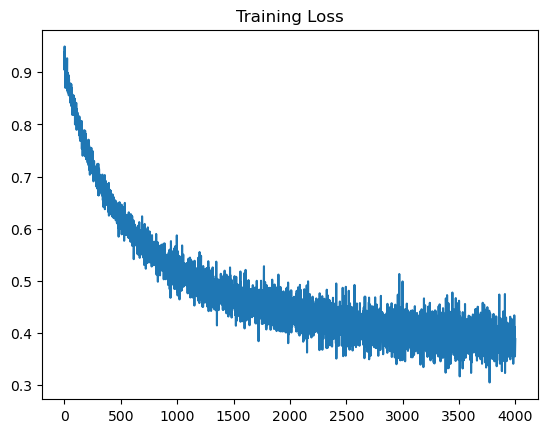

In [16]:
plt.plot(loss_logger)
_ = plt.title("Training Loss")

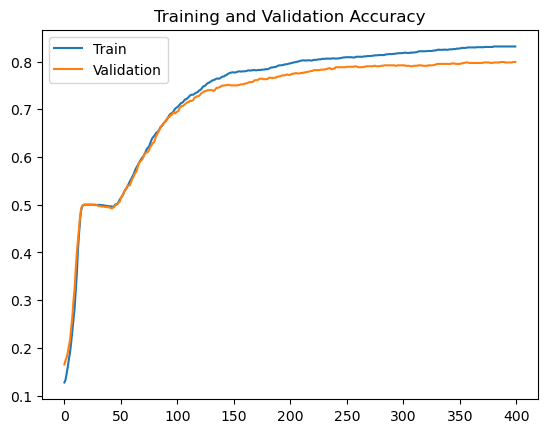

In [17]:
plt.plot(train_acc)
plt.plot(val_acc)
_ = plt.title("Training and Validation Accuracy")
plt.legend(["Train", "Validation"])

Now we can use the test set to give us the final word on how good our model is!

In [ ]:
test_accuracy = eval_loop(test_data, test_labels, linear, batch_size=50)
print("Test Accuracy is %.2f%%" % (100 * test_accuracy))

For this simple example we would expect our model to perfrom similarly accross the train/val/test split, however for more complicated datasets and models there will be a difference, in this case it is the final test accuracy that we really care about! The train/val accuracies are biased and after training don't really tell us much about the quality of the model!